# Receiving and processing satellite data transmitted via the Automatic Picture Transmission (APT) protocol 

The notebook explain how to decode data from the NOAA weather satellites (NOAA 15, NOAA 18 and NOAA 19).
The satellite use the Automatic Picture Transmission (APT) protocol and can be easily received using a (relatively inexpensive) software-defined radio and antenna for 137 MHz (following for example these instructions).


Source: https://github.com/Alexander-Barth/APTDecoder.jl/examples


Missing packages can be installed via the following julia commands (here to install the package `Images` for example).

```julia
using Pkg
Pkg.add("Images")
```

The package `APTDecoder` is installed by:

```julia
using Pkg
Pkg.develop(PackageSpec(url="https://github.com/Alexander-Barth/APTDecoder.jl"))
```

In [1]:
using Images
using FileIO
import APTDecoder
import SatelliteToolbox
using Statistics
using PyPlot
import DSP

Download a sample data file. Note the file name containts the date and time (in UTC) of the recording (year, month, day, hour, minutes and seconds) as well as the center frequency in Hz.

In [2]:
# file name as recorded by gqrx
wavname = "gqrx_20190825_182745_137620000.wav"

if !isfile(wavname)
   download("https://archive.org/download/gqrx_20190825_182745_137620000/gqrx_20190825_182745_137620000.wav",wavname)
end

This file is thus from the August 25, 2019 18:27:45 measuring at 137620000 Hz.

Name of the satellite, as used by www.celestrak.com

In [3]:
satellite_name = "NOAA 15"

"NOAA 15"

Load the satellite orbit information [TLE (Two-line element)](https://en.wikipedia.org/wiki/Two-line_element_set). A current version of this file can be downloaded from https://www.celestrak.com/NORAD/elements/weather.txt. Here we use an older version valid at the time when the satellite data was received.

In [4]:
tles = SatelliteToolbox.read_tle("weather-20190825.txt")

54-element Vector{SatelliteToolbox.SatelliteToolboxTLE.TLE}:
 TLE: DMSP 5D-2 F14 (USA 131) (Epoch = 2019-08-25T12:12:46.660)
 TLE: NOAA 15 (Epoch = 2019-08-25T13:13:48.340)
 TLE: DMSP 5D-3 F15 (USA 147) (Epoch = 2019-08-25T13:40:21.273)
 TLE: METEOSAT-8 (MSG-1) (Epoch = 2019-08-25T15:21:16.646)
 TLE: DMSP 5D-3 F16 (USA 172) (Epoch = 2019-08-25T13:05:08.154)
 TLE: NOAA 18 (Epoch = 2019-08-25T13:41:25.984)
 TLE: METEOSAT-9 (MSG-2) (Epoch = 2019-08-25T07:04:21.348)
 TLE: HIMAWARI-7 (MTSAT-2) (Epoch = 2019-08-24T21:38:19.581)
 TLE: FORMOSAT-3 FM6 (Epoch = 2019-08-25T12:52:05.885)
 TLE: FORMOSAT-3 FM1 (Epoch = 2019-08-24T11:55:51.835)
 TLE: FORMOSAT-3 FM5 (Epoch = 2019-08-24T22:26:25.700)
 TLE: FORMOSAT-3 FM3 (Epoch = 2019-08-25T12:12:34.482)
 TLE: FORMOSAT-3 FM4 (Epoch = 2019-08-25T12:02:02.564)
 ⋮
 TLE: CYGFM01 (Epoch = 2019-08-24T22:10:17.734)
 TLE: CYGFM08 (Epoch = 2019-08-24T22:20:30.573)
 TLE: CYGFM06 (Epoch = 2019-08-24T21:36:49.050)
 TLE: CYGFM07 (Epoch = 2019-08-24T22:40:34.319)
 T

Load the wav file

In [5]:
y,Fs,nbits,opt = FileIO.load(wavname)

([-0.0024719992675557726 -0.0024719992675557726; -0.001098666341135899 -0.001098666341135899; … ; -0.007324442274239326 -0.007324442274239326; -0.003326517532883694 -0.003326517532883694], 48000.0f0, 0x0010, WAV.WAVChunk[WAV.WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x02, 0x00, 0x80, 0xbb, 0x00, 0x00, 0x00, 0xee, 0x02, 0x00, 0x04, 0x00, 0x10, 0x00])])

The array `y` contains the data sampled as a frequency `Fs`:

In [6]:
size(y)

(18549922, 2)

In [7]:
Fs

48000.0f0

Duration in minutes

In [8]:
@show size(y,1) / (Fs*60)

size(y, 1) / (Fs * 60) = 6.440945f0


6.440945f0

In [9]:
1/(20/Fs)

2400.0f0

The two channels (for stereo audio) contain the same information:

In [10]:
y[(0:10) .+ 10000,:]

11×2 Matrix{Float64}:
 -0.00433363  -0.00433363
 -0.00244148  -0.00244148
  0.00173956   0.00173956
  0.00595111   0.00595111
  0.00909452   0.00909452
  0.00735496   0.00735496
  0.00598163   0.00598163
  0.0106815    0.0106815
  0.0117191    0.0117191
  0.00668355   0.00668355
  0.00543229   0.00543229

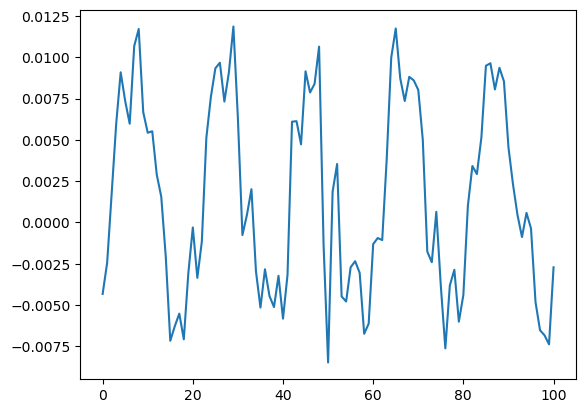

In [11]:
plot(y[(0:100) .+ 10000,1]);

We see a signal with a periodicity of about 20 samples, which correspond to a frequency (in Hz) of:

In [12]:
Fs/20

2400.0f0

2400 Hz is the carrier frequency of the amplitude-modulated signal

The power spectral density (PSD) clearly shows the peak of the carrier frequency in red.

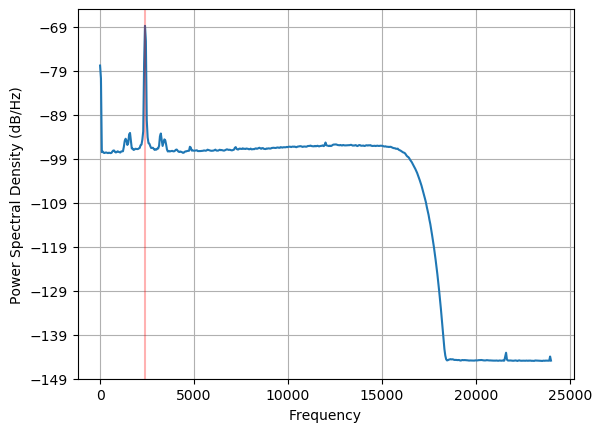

In [13]:
psd(y[:,1],Fs = Fs, NFFT=1024)
axvline(x=2400,color="r",alpha = 0.3);

Next we apply a low and high frequency for the band-pass filter (in Hz)

In [14]:
wpass = (400., 4400.)

(400.0, 4400.0)

In [15]:
responsetype = DSP.Filters.Bandpass(wpass[1],wpass[2],fs = Fs);
designmethod = DSP.Filters.Butterworth(6);

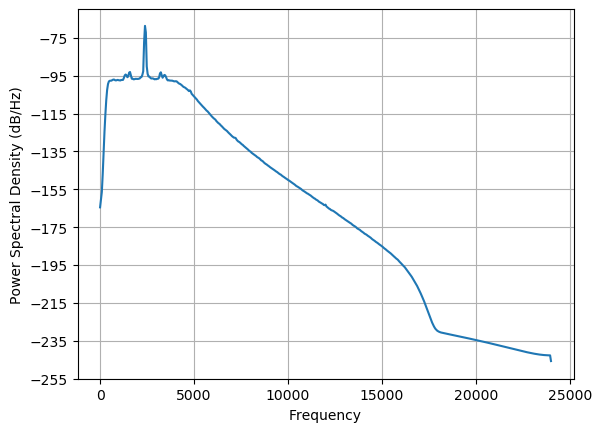

In [16]:
yf = DSP.filt(DSP.digitalfilter(responsetype, designmethod), y[:,1]);
psd(yf[:,1],Fs = Fs, NFFT=1024);

Reduce the frequency by filtering and resampling

In [17]:
Fs2 = 3*4160

12480

In [18]:
y2 = DSP.Filters.resample(yf, float(Fs2) / float(Fs) );

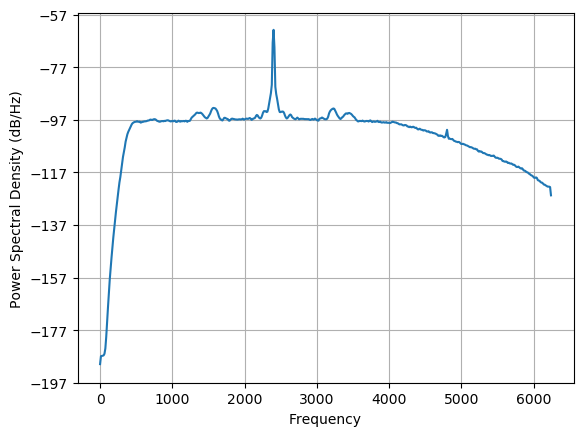

In [19]:
psd(y2,Fs = Fs2, NFFT=1024);

AM demodulation using the Hilbert Transform

In [20]:
am_demodulation(y2) = abs.(DSP.Util.hilbert(y2))

am_demodulation (generic function with 1 method)

In [21]:
y_demod = am_demodulation(y2);

The data containts two syncronization signals at 832 Hz and 1040 Hz visible as two areas with gray stripes for both channels.

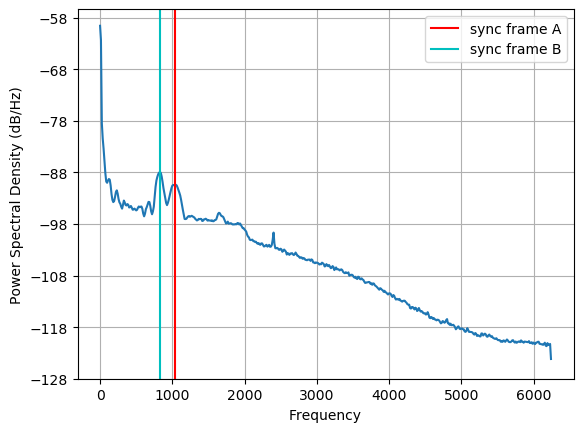

In [22]:
psd(y_demod,Fs = Fs2, NFFT=1024)
axvline(x=1040,label="sync frame A",color="r")
axvline(x=832,label="sync frame B",color="c")
legend();

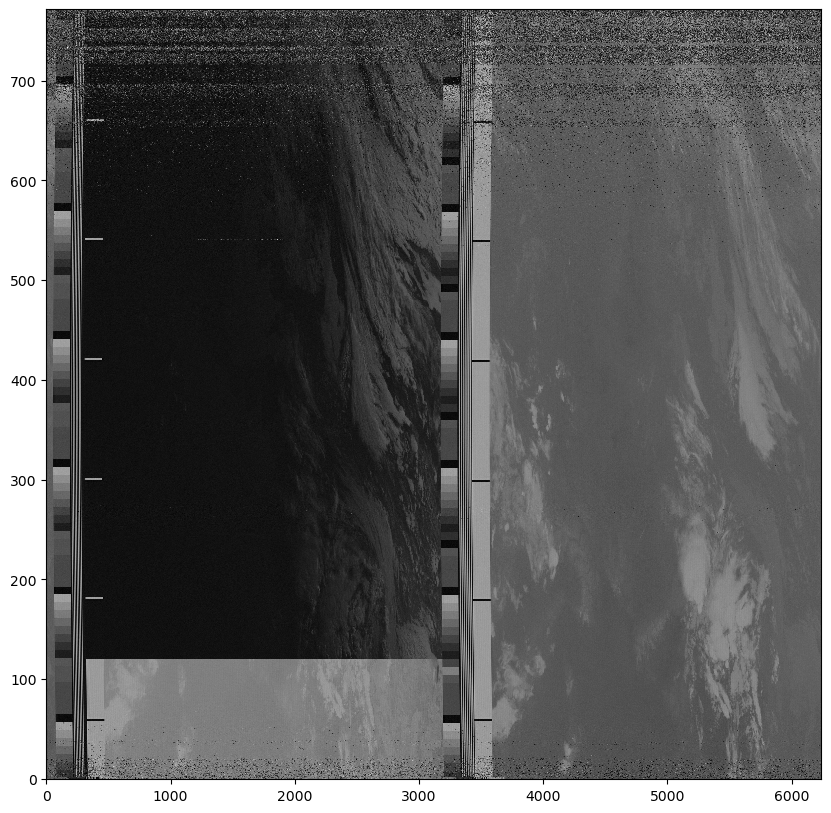

In [23]:
scans_per_seconds = 2    
# length of a frame
frame_len = round(Int,Fs2/scans_per_seconds)
nscan = length(y_demod) ÷ frame_len

figure(figsize=(10,10))
imshow(reshape(y_demod[1:frame_len*nscan],(frame_len,nscan))', aspect="auto", cmap="gray");
gca().invert_yaxis()

In [24]:
# decode to image
datatime,(channelA,channelB),data = APTDecoder.decode(y,Fs)

vmin,vmax = quantile(view(data,:),[0.01,0.99])
data[data .> vmax] .= vmax;
data[data .< vmin] .= vmin;

rawname = replace(wavname,r".wav$" => "_raw.png")
FileIO.save(rawname, colorview(Gray, data[:,1:3:end]./maximum(data)))

0

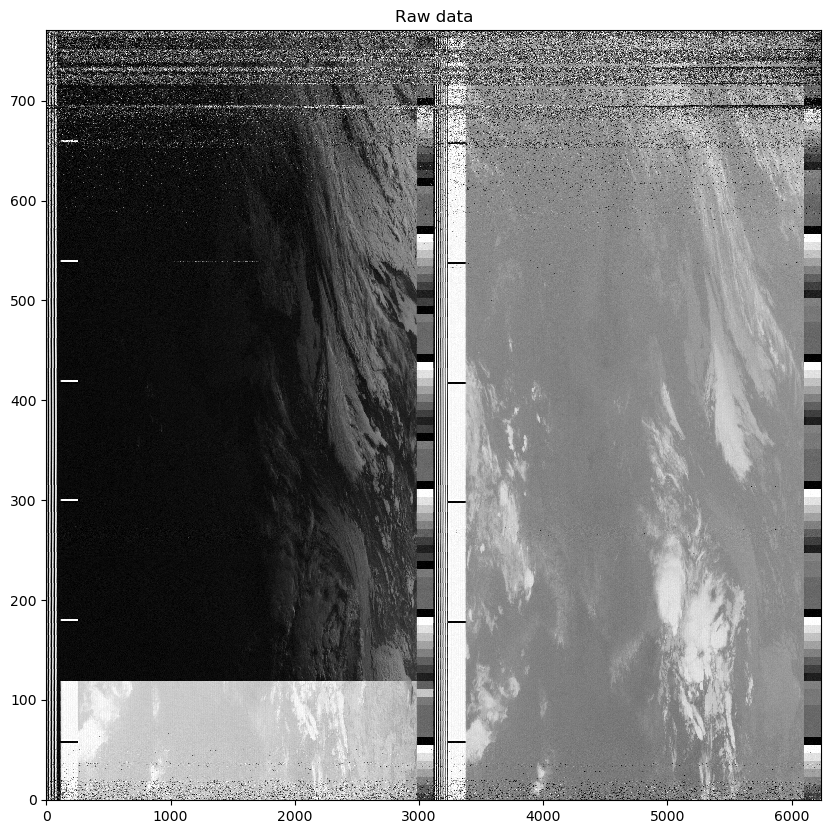

In [25]:
figure("APTDecoder",figsize = (10,10))
imshow(data, aspect="auto", cmap="gray");
gca().invert_yaxis()
title("Raw data");

In [26]:
starttime = APTDecoder.starttimename(wavname)

# TLEs are downloaded if omited
Alon,Alat,Adata = APTDecoder.georeference(channelA,satellite_name,datatime,starttime; tles=tles);

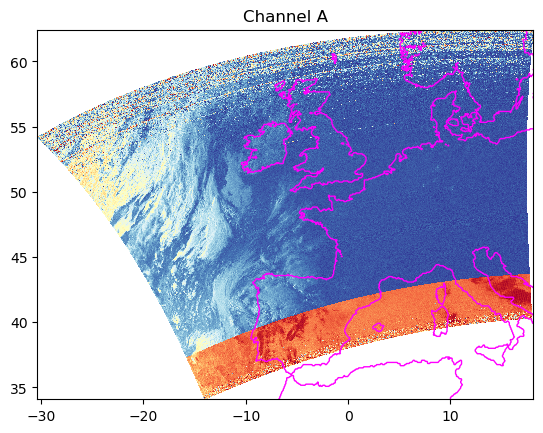

In [27]:
APTDecoder.plot(Alon,Alat,Adata)
title("Channel A");

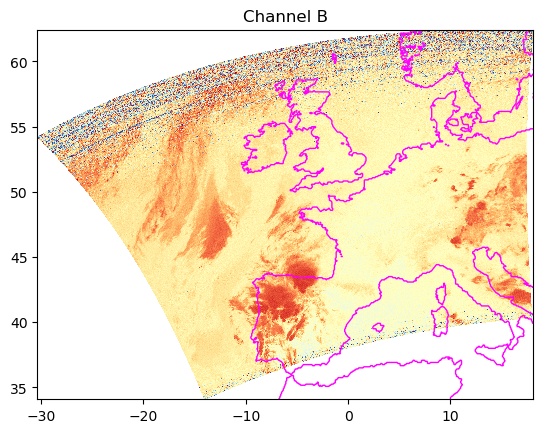

In [28]:
Blon,Blat,Bdata = APTDecoder.georeference(channelB,satellite_name,datatime,starttime; tles=tles)
APTDecoder.plot(Blon,Blat,Bdata)
title("Channel B");

## References

https://en.wikipedia.org/wiki/Automatic_picture_transmission